<a id="section_ID"></a>

# Predicting superconducting transition temperature from elemental physical properties

In this notebook, the following models are used to predict the superconducting transition temperature (y) from various elemental properties (X).
- [OLS](#ols)
- [Lasso](#lasso)
- [Ridge](#ridge)
- [XGBoost](#xgbtree)
    - [Select k best](#selectkbest)
    - [Select from lasso](#selectfromlasso)
    - [Recursive feature elimination](#rfe)
    - [PCA](#pca)

***

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from bayes_opt import BayesianOptimization
from sklearn.base import BaseEstimator
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, RFE, RFECV, SelectFromModel, SequentialFeatureSelector, f_regression, mutual_info_regression
from sklearn import __version__ as sklearn_version
import datetime
import xgboost as xgb
import sys
from joblib import dump

# Import data and split train-test

In [2]:
#import the cleaned data
data = pd.read_csv('../data/processed/data_cleaned.csv')

In [3]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [5]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

***

# OLS<a id='ols'><a>

Try the most simple model.

Since ranges of each feature are on different scale, use StandardScaler first. 

In [6]:
steps = [('scaler', StandardScaler()), ('ols', LinearRegression())]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'test rmse: {rmse:.2f}, r2: {r2:.2f}')

test rmse: 17.61, r2: 0.74


## Select k best

Check if selecting feature can improve the model.

In [9]:
steps = [('scaler', StandardScaler()), ('selectkbest', SelectKBest(f_regression)), ('ols', LinearRegression())]
pipeline_ols_k = Pipeline(steps)
k = [k for k in range(1,X_train.shape[1]+1)]
parameters = {'selectkbest__k':k}
ols_k_cv = GridSearchCV(pipeline_ols_k, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=kf)
ols_k_cv.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000019E3A8D72E0>)),
                                       ('ols', LinearRegression())]),
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]},
             scoring='neg_root_mean_squared_error')

In [10]:
ols_k_cv.best_params_, -ols_k_cv.best_score_

({'selectkbest__k': 81}, 17.601118480113513)

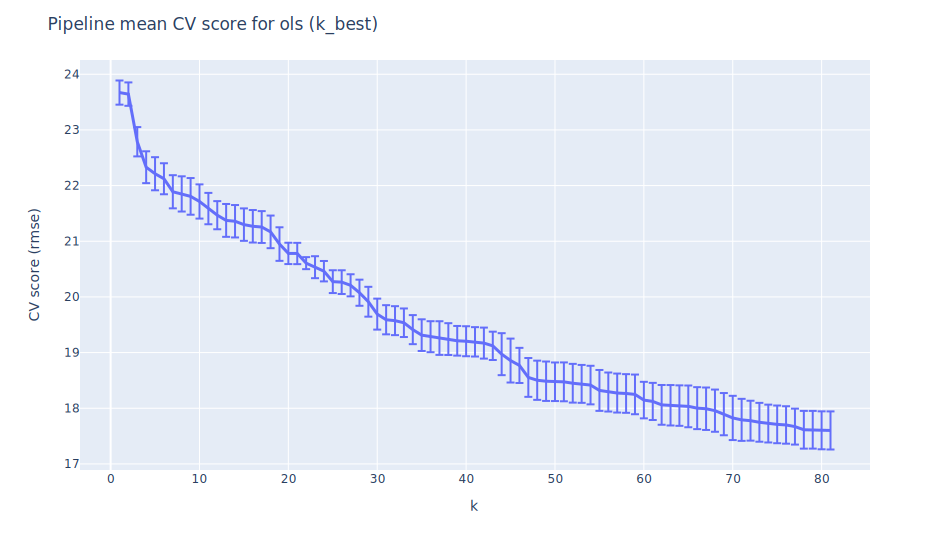

In [11]:
score_mean = -ols_k_cv.cv_results_['mean_test_score']
score_std = ols_k_cv.cv_results_['std_test_score']
fig = px.line(x=k, y=score_mean, error_y=score_std)
fig.update_traces(line={'width':3})
fig.update_layout(template = 'plotly', title='Pipeline mean CV score for ols (k_best)',
                  yaxis_title='CV score (rmse)',xaxis_title='k', width=950, height=550)
fig.show('svg')

The best k is 81 and the score keep decreasing with increasing k.

## Coefficients

Check coefficients of the ols.

In [12]:
coef = ols_k_cv.best_estimator_.named_steps.ols.coef_
coef_df = pd.DataFrame({'feature': X_train.columns, 'coefficient': coef})
topten_ols = coef_df.nlargest(10, 'coefficient')
topten_ols

feature  coefficient
22        wtd_mean_atomic_radius    91.021947
72              wtd_mean_Valence    33.719440
75               entropy_Valence    29.304128
49          std_ElectronAffinity    26.442875
14                 wtd_gmean_fie    25.381237
25         entropy_atomic_radius    25.255210
73                 gmean_Valence    24.815887
1               mean_atomic_mass    24.713880
62  wtd_mean_ThermalConductivity    22.922783
4          wtd_gmean_atomic_mass    22.669077

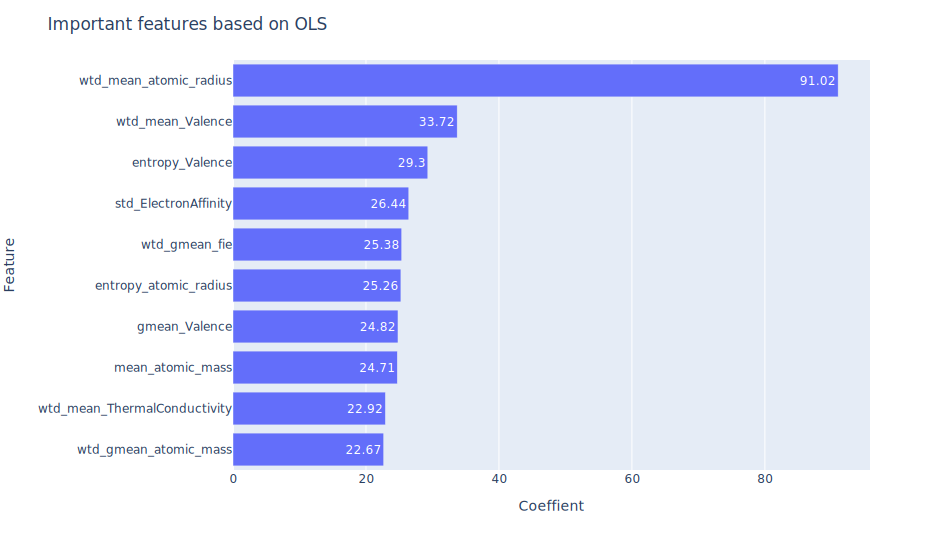

In [13]:
fig = px.bar(x=topten_ols.coefficient[::-1], y=topten_ols.feature[::-1], text_auto='.4', width=950, height=550)
fig.update_layout(template = 'plotly', title='Important features based on OLS',yaxis_title='Feature',
                  xaxis_title='Coeffient')
fig.show('svg')

The most important feature is __weighted mean atomic radius__.

## Result

Best model of ols is just the base model.

In [14]:
y_pred = ols_k_cv.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'test rmse: {rmse:.2f}, r2: {r2:.2f}')

test rmse: 17.61, r2: 0.74


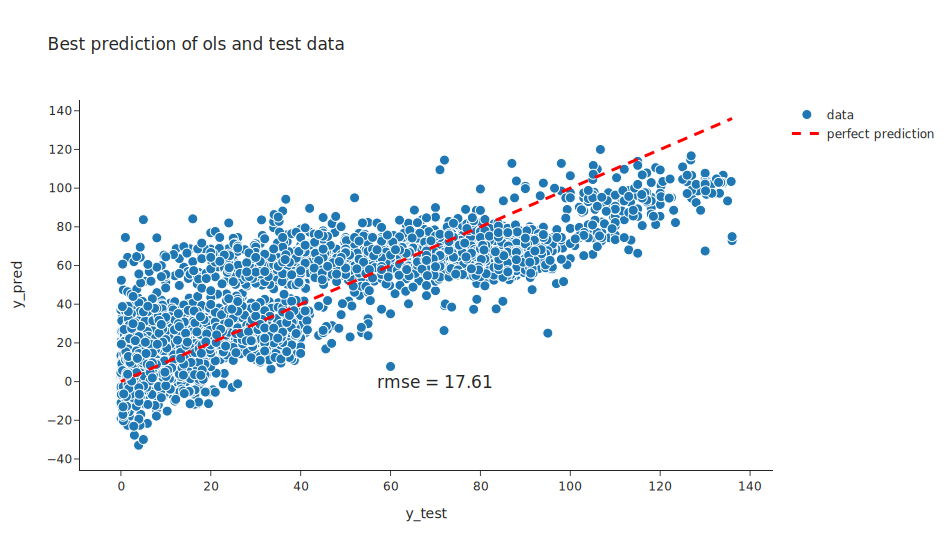

In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_pred, name='data',mode='markers', marker=dict(size=10,line=dict(width=1, color='white'))))
fig.add_trace(go.Scatter(x=y_test, y=y_test, name='perfect prediction',mode='lines', line=dict(dash='dash', color='red', width=3)))
fig.add_annotation(x=70, y=0, text=f'rmse = {rmse:.2f}', showarrow=False,  font={'size':17})
fig.update_layout(template = 'simple_white', title='Best prediction of ols and test data',
                  yaxis_title='y_pred',xaxis_title='y_test', showlegend=True, width=950, height=550)
fig.show('svg')

***

# Lasso<a id='lasso'><a>

Do GridSearchCV with alpha in Lasso.

In [ ]:
steps = [('scaler', StandardScaler()), ('lasso', Lasso(max_iter=100000))]
# increase max_iter to avoid divergence
pipeline_lasso = Pipeline(steps)
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
parameters = {'lasso__alpha':alpha}
lasso_cv = GridSearchCV(pipeline_lasso, param_grid=parameters, scoring='neg_root_mean_squared_error')
lasso_cv.fit(X_train, y_train)

In [41]:
lasso_cv.best_params_, -lasso_cv.best_score_

({'lasso__alpha': 0.0001}, 17.590319286121414)

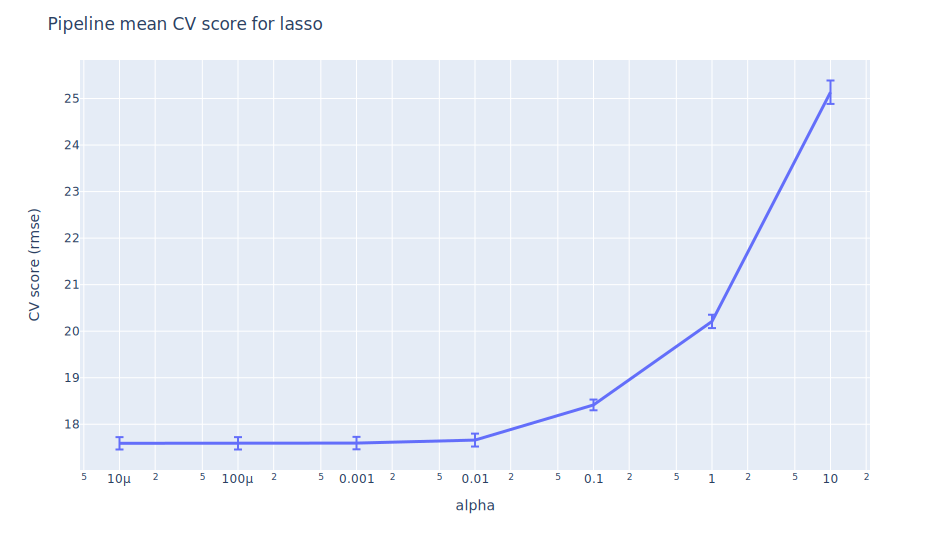

In [247]:
result = pd.DataFrame({'alpha':lasso_cv.cv_results_['param_lasso__alpha'], 
                       'mean':-lasso_cv.cv_results_['mean_test_score'], 'std':lasso_cv.cv_results_['std_test_score']})
fig = px.line(result, x='alpha', y='mean', error_y='std', log_x=True)
fig.update_traces(line={'width':3})
fig.update_layout(template = 'plotly', title='Pipeline mean CV score for lasso',yaxis_title='CV score (rmse)',
                  xaxis_title='alpha', width=950, height=550)
fig.show('svg')

## Coefficients

Check coefficients

In [45]:
coef = lasso_cv.best_estimator_.named_steps.lasso.coef_
coef_df = pd.DataFrame({'feature': X_train.columns, 'coefficient': coef})
topten_lasso = coef_df.nlargest(10, 'coefficient')
topten_lasso

feature  coefficient
22        wtd_mean_atomic_radius    89.176098
72              wtd_mean_Valence    31.983121
75               entropy_Valence    29.007747
49          std_ElectronAffinity    26.465963
1               mean_atomic_mass    24.351358
25         entropy_atomic_radius    23.978465
73                 gmean_Valence    23.726517
62  wtd_mean_ThermalConductivity    22.952193
14                 wtd_gmean_fie    22.945166
4          wtd_gmean_atomic_mass    22.136501

The most important feature is __weighted mean atomic radius__.

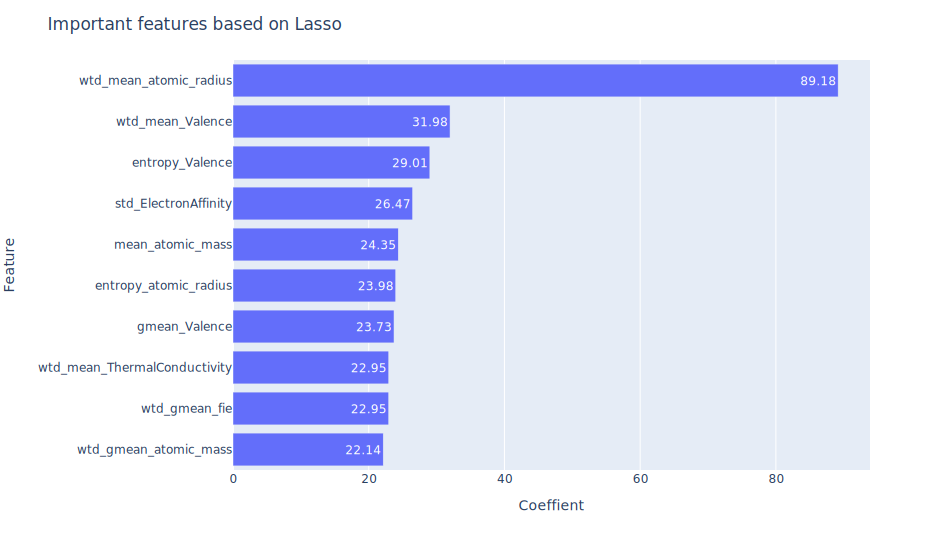

In [46]:
fig = px.bar(x=topten_lasso.coefficient[::-1], y=topten_lasso.feature[::-1], text_auto='.4', width=950, height=550)
fig.update_layout(template = 'plotly', title='Important features based on Lasso',yaxis_title='Feature',
                  xaxis_title='Coeffient')
fig.show('svg')

## Result

The best model of lasso is 'lasso__alpha': 0.0001.

In [256]:
y_pred = lasso_cv.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'test rmse: {rmse:.2f}, r2: {r2:.2f}')

test rmse: 17.61, r2: 0.74


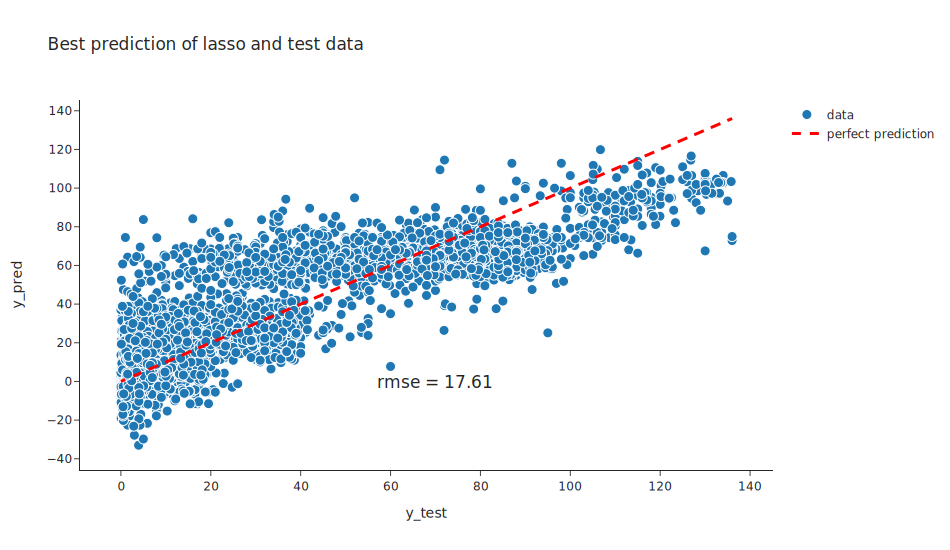

In [48]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_pred, name='data',mode='markers', 
                         marker=dict(size=10, line=dict(width=1, color='white'))))
fig.add_trace(go.Scatter(x=y_test, y=y_test, name='perfect prediction',mode='lines', 
                         line=dict(dash='dash', color='red', width=3)))
fig.add_annotation(x=70, y=0, text=f'rmse = {rmse:.2f}', showarrow=False,  font={'size':17})
fig.update_layout(template = 'simple_white', title='Best prediction of lasso and test data',
                  yaxis_title='y_pred',xaxis_title='y_test', showlegend=True, width=950, height=550)
fig.show('svg')

***

# Ridge<a id='ridge'><a>

## Select k best

In [140]:
steps = [('scaler', StandardScaler()), ('selectkbest', SelectKBest(f_regression)), ('ridge', Ridge())]
pipeline = Pipeline(steps)
k = [k for k in range(1, X_train.shape[1]+1)]
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
parameters = {'selectkbest__k':k, 'ridge__alpha':alpha}
ridge_k_cv = GridSearchCV(pipeline, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=kf)
ridge_k_cv.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000019E3A8D72E0>)),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                          10],
                         'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]},
             scoring='neg_root_mean_squared_error')

In [141]:
ridge_k_cv.best_params_, -ridge_k_cv.best_score_

({'ridge__alpha': 0.1, 'selectkbest__k': 81}, 17.600926724512263)

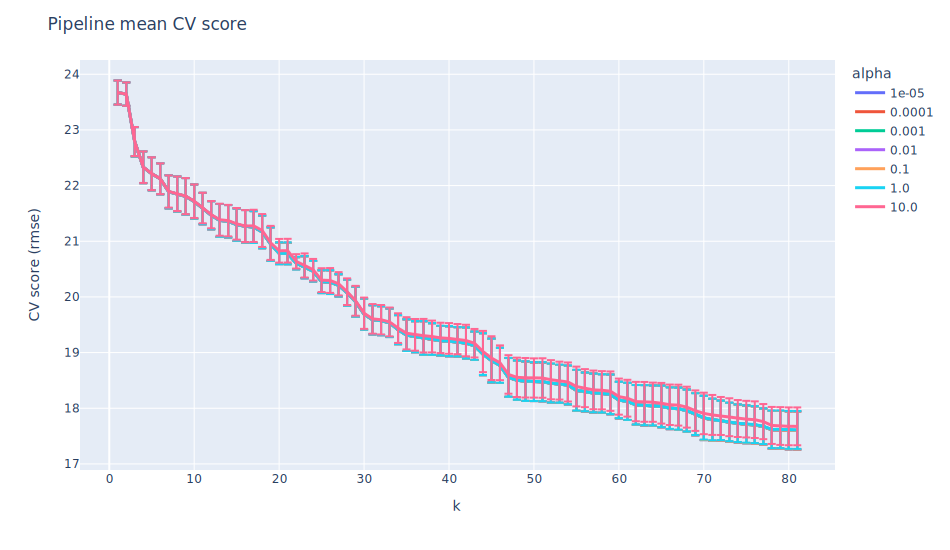

In [142]:
result = pd.DataFrame({'alpha':ridge_k_cv.cv_results_['param_ridge__alpha'], 'k':ridge_k_cv.cv_results_['param_selectkbest__k'],
                       'mean':-ridge_k_cv.cv_results_['mean_test_score'], 'std':ridge_k_cv.cv_results_['std_test_score']})
fig = px.line(result, x='k', y='mean', error_y='std', color='alpha')
fig.update_traces(line={'width':3})
fig.update_layout(template = 'plotly', title='Pipeline mean CV score',yaxis_title='CV score (rmse)',
                  xaxis_title='k', width=950, height=550)
fig.show('svg')

## Coefficients

Check coefficient

In [143]:
coef = ridge_k_cv.best_estimator_.named_steps.ridge.coef_
coef_df = pd.DataFrame({'feature': X_train.columns, 'coefficient': coef})
topten_ridge = coef_df.nlargest(10, 'coefficient')
topten_ridge

feature  coefficient
22        wtd_mean_atomic_radius    86.035328
72              wtd_mean_Valence    31.039135
75               entropy_Valence    28.595790
49          std_ElectronAffinity    26.540539
1               mean_atomic_mass    24.149887
73                 gmean_Valence    23.234235
62  wtd_mean_ThermalConductivity    22.939979
25         entropy_atomic_radius    22.692273
17                     range_fie    21.789091
4          wtd_gmean_atomic_mass    21.729281

The most important feature is __weighted mean atomic radius__.

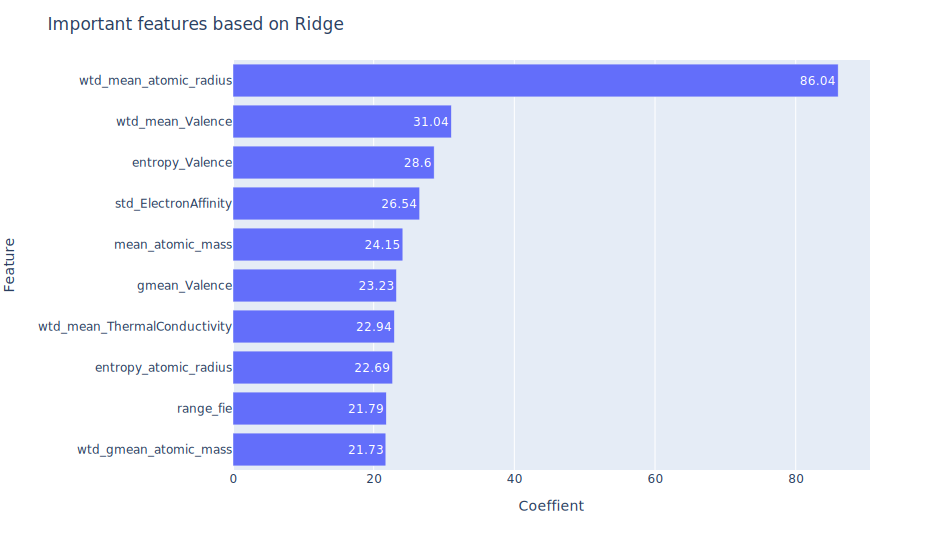

In [144]:
fig = px.bar(x=topten_ridge.coefficient[::-1], y=topten_ridge.feature[::-1], text_auto='.4')
fig.update_layout(template = 'plotly', title='Important features based on Ridge',yaxis_title='Feature',
                  xaxis_title='Coeffient', width=950, height=550)
fig.show('svg')

## Result

The best model of ride is 'ridge__alpha': 0.1, 'selectkbest__k': 81.

In [145]:
y_pred = ridge_k_cv.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'test rmse: {rmse:.2f}, r2: {r2:.2f}')

test rmse: 17.61, r2: 0.74


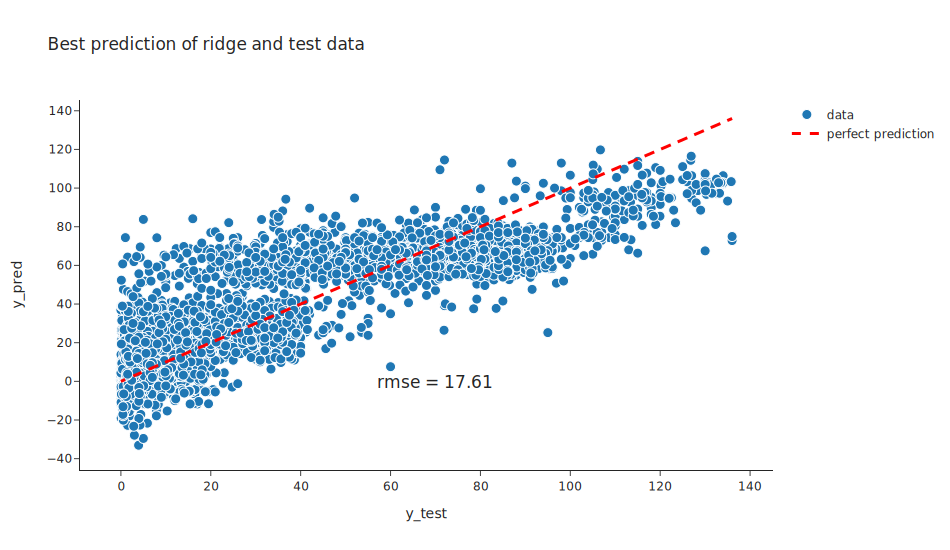

In [146]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_pred, name='data',mode='markers', 
                         marker=dict(size=10, line=dict(width=1, color='white'))))
fig.add_trace(go.Scatter(x=y_test, y=y_test, name='perfect prediction',mode='lines', 
                         line=dict(dash='dash', color='red', width=3)))
fig.add_annotation(x=70, y=0, text=f'rmse = {rmse:.2f}', showarrow=False,  font={'size':17})
fig.update_layout(template = 'simple_white', title='Best prediction of ridge and test data',
                  yaxis_title='y_pred',xaxis_title='y_test', showlegend=True, width=950, height=550)
fig.show('svg')

***

# XGBoost<a id='xgbtree'><a>

Since there are many hyperparameters, use __BayesianOptimization__.

Define optimatiation function with mean of cross_val_score

In [136]:
def generate_xgb_eval(X_train, y_train):
    def xgb_eval(n_estimators:int, max_depth:int, learning_rate:float, gamma:float, reg_alpha:float, reg_lambda:float, 
             subsample:float, colsample_bytree:float)->float:
        # n_estimators and max_depth has to be int.
        xgb_param_grid = {'objective':'reg:squarederror', 'n_estimators':int(n_estimators), 'max_depth':int(max_depth),
                      'learning_rate':learning_rate, 'gamma':gamma, 'reg_alpha':reg_alpha, 'reg_lambda':reg_lambda,
                     'subsample':subsample, 'colsample_bytree':colsample_bytree}
        xgb_reg = xgb.XGBRegressor(**xgb_param_grid)
        score = cross_val_score(xgb_reg, X_train, y_train, scoring='neg_root_mean_squared_error', cv=kf)
        return score.mean()
    return xgb_eval

In [137]:
xgb_param_grid = {'n_estimators':(100,300.99), 'max_depth':(1,20.99),
                      'learning_rate':(0.01,1), 'gamma':(0.0 ,1.0), 'reg_alpha':(0.0,1.0), 'reg_lambda':(0.0,1.0),
                     'subsample':(0.01, 1.0), 'colsample_bytree':(0.01, 1.0)}

In [138]:
xgb_eval = generate_xgb_eval(X_train, y_train)
xgb_opt = BayesianOptimization(xgb_eval, xgb_param_grid, random_state=0)
xgb_opt.maximize(n_iter=20, init_points=5)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | -11.48    | 0.5533    | 0.7152    | 0.6067    | 11.89     | 185.2     | 0.6459    | 0.4376    | 0.8929    |
| 2         | -8.805e+0 | 0.964     | 0.3834    | 0.7938    | 11.57     | 214.2     | 0.9256    | 0.07104   | 0.09626   |
| 3         | -18.07    | 0.03002   | 0.8326    | 0.7804    | 18.39     | 296.7     | 0.7992    | 0.4615    | 0.7827    |
| 4         | -10.19    | 0.1271    | 0.6399    | 0.1519    | 19.88     | 204.9     | 0.4147    | 0.2646    | 0.7765    |
| 5         | -9.491    | 0.4616    | 0.5684    | 0.0286    | 13.35     | 223.0     | 0.6169    | 0.9437    | 0.685     |
| 6         | -29.87    | 0.6182    | 0.8174    | 0.7124    | 15.93     | 256.0     | 0.7037    | 0.1164    | 0.3405    |
| 7         | -12.35    

In [139]:
xgb_opt.max

{'target': -9.490946931958375,
 'params': {'colsample_bytree': 0.4615888288943831,
  'gamma': 0.5684339488686485,
  'learning_rate': 0.028601902431991594,
  'max_depth': 13.346533586546782,
  'n_estimators': 223.0251193099795,
  'reg_alpha': 0.6169339968747569,
  'reg_lambda': 0.9437480785146242,
  'subsample': 0.6850020961124486}}

In [75]:
params = xgb_opt.max['params']
#change n_estimators and max_depth to int
params['n_estimators'] = int(params['n_estimators'])
params['max_depth'] = int(params['max_depth'])

## Select k best<a id='selectkbest'><a>

Try select k best feature with __f_regression__ using the hyperparameters from above.

In [156]:
steps = [('scaler', StandardScaler()), ('selectkbest', SelectKBest(f_regression)), ('xgb', xgb.XGBRegressor(**params))]
pipeline_xgb_f = Pipeline(steps)
k = [k for k in range(1, X_train.shape[1]+1)]
parameters = {'selectkbest__k':k}
xgb_f_cv = GridSearchCV(pipeline_xgb_f, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=kf)
xgb_f_cv.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000019E3A8D72E0>)),
                                       ('xgb',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=0.4615888288943831,
                                                     early_...
                                                     max_delta_step=None,
                                                     max_depth=13,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=223,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))]),
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]},
             scoring='neg_root_mean_squared_error')

check best score

In [157]:
xgb_f_cv.best_params_, -xgb_f_cv.best_score_

({'selectkbest__k': 80}, 9.491470375408579)

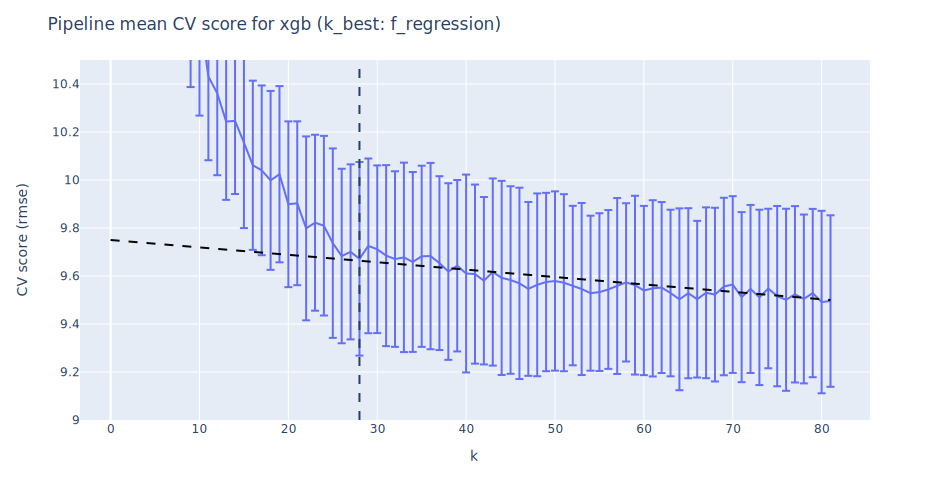

In [182]:
score_mean = -xgb_f_cv.cv_results_['mean_test_score']
score_std = xgb_f_cv.cv_results_['std_test_score']

fig = px.line(x=k, y=score_mean, error_y=score_std)
fig.add_trace(go.Scatter(x=[0, 81], y=[9.75,9.5], mode='lines', 
                         line=dict(dash='dash',color='black', width=2), showlegend=False))

fig.add_vline(x=28, line_width=2, line_dash="dash")

fig.update_yaxes(range=(9,10.5))

fig.update_xaxes(title_text='k')

fig.update_layout(template = 'plotly', title='Pipeline mean CV score for xgb (k_best: f_regression)',
                  yaxis_title='CV score (rmse)', width=950, height=500)

fig.show('svg')

Score is stable around 28. More features have diminishing return and may lead to overfit.

In [162]:
-xgb_f_cv.cv_results_['mean_test_score'][27]

9.671690827649886

Refit at k=28.

In [163]:
steps = [('scaler', StandardScaler()), ('selectkbest', SelectKBest(f_regression, k=28)), ('xgb', xgb.XGBRegressor(**params))]
pipeline_xgb_f_28 = Pipeline(steps)
pipeline_xgb_f_28.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=28,
                             score_func=<function f_regression at 0x0000019E3A8D72E0>)),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.4615888288943831,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feat...
                              gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.028601902431991594, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=13,
                              max_leaves=None, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              n_estimators=223, n_jobs=None,
                              num_parallel_tree=None, predictor=None,
                              random_state=None, ...))])

## Importance features

In [164]:
importances = pipeline_xgb_f_28.named_steps.xgb.feature_importances_
importance_df = pd.DataFrame({'feature': X.columns[pipeline_xgb_f_28.named_steps.selectkbest.get_support()], 
                              'importance': importances})
topten_xgb_f = importance_df.nlargest(10, 'importance')
topten_xgb_f

feature  importance
18      range_ThermalConductivity    0.547673
10            range_atomic_radius    0.111756
27            wtd_entropy_Valence    0.044628
21    wtd_std_ThermalConductivity    0.043930
20        std_ThermalConductivity    0.029754
23               wtd_mean_Valence    0.024931
24                  gmean_Valence    0.022709
25              wtd_gmean_Valence    0.022345
19  wtd_range_ThermalConductivity    0.016151
15                entropy_Density    0.013931

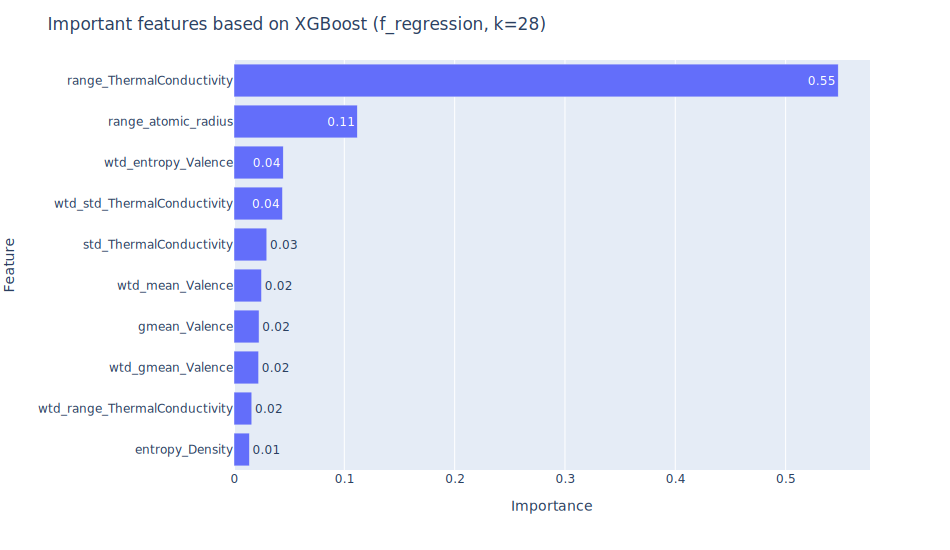

In [165]:
fig = px.bar(x=topten_xgb_f.importance[::-1], y=topten_xgb_f.feature[::-1], text_auto='.2f', width=950, height=550)
fig.update_layout(template = 'plotly', title='Important features based on XGBoost (f_regression, k=28)',
                  yaxis_title='Feature',xaxis_title='Importance')
fig.show('svg')

***

Try select k best feature with __mutual_info_regression__ with the same parameters from above.

In [166]:
steps = [('scaler', StandardScaler()), ('selectkbest', SelectKBest(mutual_info_regression)), ('xgb', xgb.XGBRegressor(**params))]
pipeline = Pipeline(steps)
k = [k for k in range(1, X_train.shape[1]+1)]
parameters = {'selectkbest__k':k}
xgb_mi_cv = GridSearchCV(pipeline, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=kf)
xgb_mi_cv.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function mutual_info_regression at 0x0000019E3A8D5080>)),
                                       ('xgb',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=0.4615888288943...
                                                     max_delta_step=None,
                                                     max_depth=13,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=223,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))]),
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]},
             scoring='neg_root_mean_squared_error')

check best score

In [167]:
xgb_mi_cv.best_params_, -xgb_mi_cv.best_score_

({'selectkbest__k': 67}, 9.458443245542096)

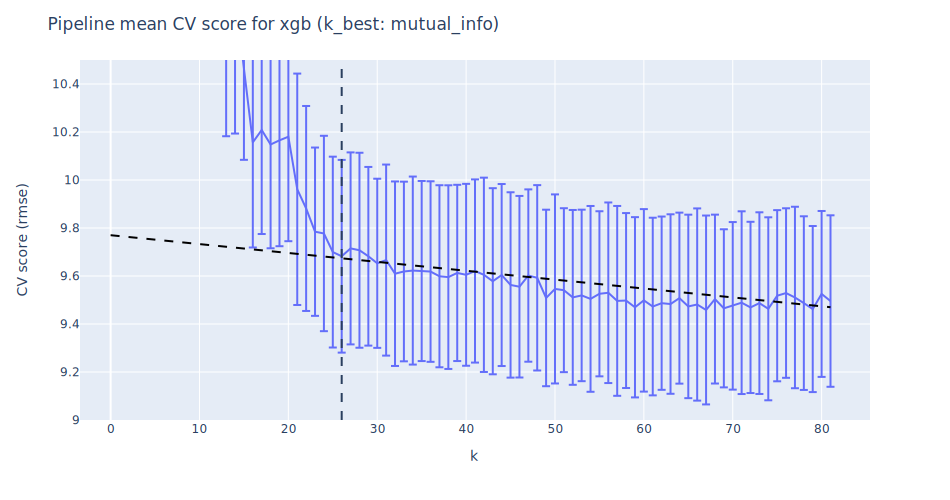

In [184]:
score_mean = -xgb_mi_cv.cv_results_['mean_test_score']
score_std = xgb_mi_cv.cv_results_['std_test_score']

fig = px.line(x=k, y=score_mean, error_y=score_std)
fig.add_trace(go.Scatter(x=[0, 81], y=[9.77,9.47], mode='lines', 
                         line=dict(dash='dash',color='black', width=2), showlegend=False))
fig.add_vline(x=26, line_width=2, line_dash="dash")

fig.update_yaxes(range=(9,10.5))

fig.update_xaxes(title_text='k')

fig.update_layout(template = 'plotly', title='Pipeline mean CV score for xgb (k_best: mutual_info)',
                  yaxis_title='CV score (rmse)', width=950, height=500)

fig.show('svg')

Score and derivative plateau around 26. More features have diminishing return and may lead to overfit.

In [185]:
-xgb_mi_cv.cv_results_['mean_test_score'][25]

9.682272232141294

Refit at k=26.

In [186]:
steps = [('scaler', StandardScaler()), ('selectkbest', SelectKBest(f_regression, k=26)), ('xgb', xgb.XGBRegressor(**params))]
pipeline_xgb_mi_26 = Pipeline(steps)
pipeline_xgb_mi_26.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=26,
                             score_func=<function f_regression at 0x0000019E3A8D72E0>)),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.4615888288943831,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feat...
                              gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.028601902431991594, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=13,
                              max_leaves=None, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              n_estimators=223, n_jobs=None,
                              num_parallel_tree=None, predictor=None,
                              random_state=None, ...))])

## Important features

In [187]:
importances = pipeline_xgb_mi_26.named_steps.xgb.feature_importances_
importance_df = pd.DataFrame({'feature': X.columns[pipeline_xgb_mi_26.named_steps.selectkbest.get_support()], 
                              'importance': importances})
topten_xgb_mi_26 = importance_df.nlargest(10, 'importance')
topten_xgb_mi_26

feature  importance
17    range_ThermalConductivity    0.436439
10          range_atomic_radius    0.133103
18      std_ThermalConductivity    0.082337
19  wtd_std_ThermalConductivity    0.063447
25          wtd_entropy_Valence    0.040877
24              entropy_Valence    0.031520
22                gmean_Valence    0.031337
23            wtd_gmean_Valence    0.024594
21             wtd_mean_Valence    0.021080
15           entropy_FusionHeat    0.014707

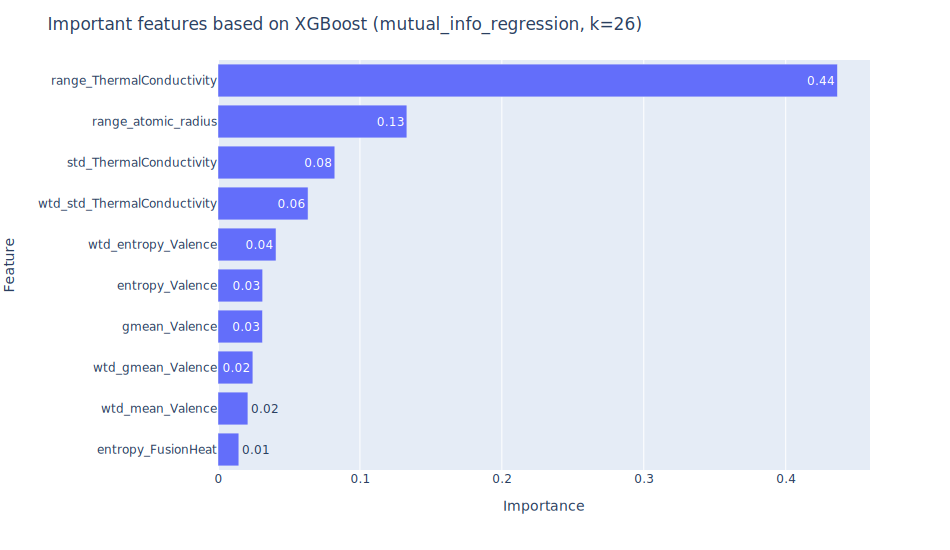

In [190]:
fig = px.bar(x=topten_xgb_mi_26.importance[::-1], y=topten_xgb_mi_26.feature[::-1], text_auto='.2f', width=950, height=550)
fig.update_layout(template = 'plotly', title='Important features based on XGBoost (mutual_info_regression, k=26)',
                  yaxis_title='Feature',xaxis_title='Importance')
fig.show('svg')

***

## Select from lasso<a id='selectfromlasso'><a>

Try use lasso to select features. Use alpha = 0.0001 obtained from the previous section.

In [106]:
steps = [('scaler', StandardScaler()), ('feature_selection', SelectFromModel(Lasso(alpha=0.0001, max_iter=100000)))]
pipeline_scale_lasso = Pipeline(steps)
X_train_scale_lasso = pipeline_scale_lasso.fit_transform(X_train, y_train)

Check numbers of features after transformation

In [132]:
X_train_scale_lasso.shape[1]

81

Cannot reduce features at all.

***

## Recursive feature elimination<a id='rfe'><a>

In [76]:
xgb_rfecv1 = RFECV(xgb.XGBRegressor(**params), scoring='neg_root_mean_squared_error', cv=kf)
xgb_rfecv1.fit(X_train, y_train)

RFECV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
      estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=0.4615888288943831,
                             early_stopping_rounds=None,
                             enable_categorical=False, eval_metric=None,
                             feature_types=None, gamma=0.5684339488686485,
                             gpu_id=None, grow_policy=None,
                             impor...n_constraints=None,
                             learning_rate=0.028601902431991594, max_bin=None,
                             max_cat_threshold=None, max_cat_to_onehot=None,
                             max_delta_step=None, max_depth=13, max_leaves=None,
                             min_child_weight=None, missing=nan,
                             monotone_constraints=None, n_estimators=223,
                             n_jobs=None, num_parallel_tree=None,
                             predictor=None, random_state=None, ...),
      scoring='neg_root_mean_squared_error')

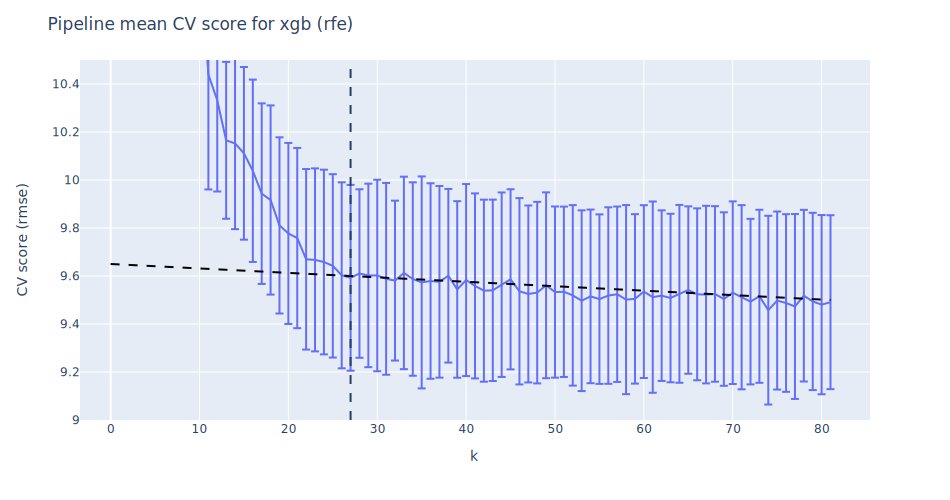

In [194]:
score_mean = -xgb_rfecv1.cv_results_['mean_test_score']
score_std = xgb_rfecv1.cv_results_['std_test_score']

fig = px.line(x=k, y=score_mean, error_y=score_std)
fig.add_trace(go.Scatter(x=[0, 81], y=[9.65,9.5], mode='lines', 
                         line=dict(dash='dash',color='black', width=2), showlegend=False))
fig.add_vline(x=27, line_width=2, line_dash="dash")

fig.update_yaxes(range=(9,10.5))

fig.update_xaxes(title_text='k')

fig.update_layout(template = 'plotly', title='Pipeline mean CV score for xgb (rfe)',
                  yaxis_title='CV score (rmse)', width=950, height=500)

fig.show('svg')

Score and derivative are stable around k=27.

In [104]:
-xgb_rfecv1.cv_results_['mean_test_score'][26]

9.592545052526601

Refit at k=27.

In [101]:
xgb_rfe = RFE(xgb.XGBRegressor(**params), n_features_to_select=27)
xgb_rfe.fit(X_train, y_train)

RFE(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                           colsample_bylevel=None, colsample_bynode=None,
                           colsample_bytree=0.4615888288943831,
                           early_stopping_rounds=None, enable_categorical=False,
                           eval_metric=None, feature_types=None,
                           gamma=0.5684339488686485, gpu_id=None,
                           grow_policy=None, importance_type=None,
                           interaction_constraints=None,
                           learning_rate=0.028601902431991594, max_bin=None,
                           max_cat_threshold=None, max_cat_to_onehot=None,
                           max_delta_step=None, max_depth=13, max_leaves=None,
                           min_child_weight=None, missing=nan,
                           monotone_constraints=None, n_estimators=223,
                           n_jobs=None, num_parallel_tree=None, predictor=None,
                           random_state=None, ...),
    n_features_to_select=27)

## Importance features

In [102]:
importances = xgb_rfe.estimator_.feature_importances_
importance_df = pd.DataFrame({'feature': X.columns[xgb_rfe.support_], 
                              'importance': importances})
topten_xgb_rfe = importance_df.nlargest(10, 'importance')
topten_xgb_rfe

feature  importance
15      range_ThermalConductivity    0.688787
2             range_atomic_radius    0.043060
24            wtd_entropy_Valence    0.024890
23                entropy_Valence    0.022351
18    wtd_std_ThermalConductivity    0.019539
21                  gmean_Valence    0.015047
22              wtd_gmean_Valence    0.014334
17        std_ThermalConductivity    0.013354
16  wtd_range_ThermalConductivity    0.012603
13  wtd_gmean_ThermalConductivity    0.010889

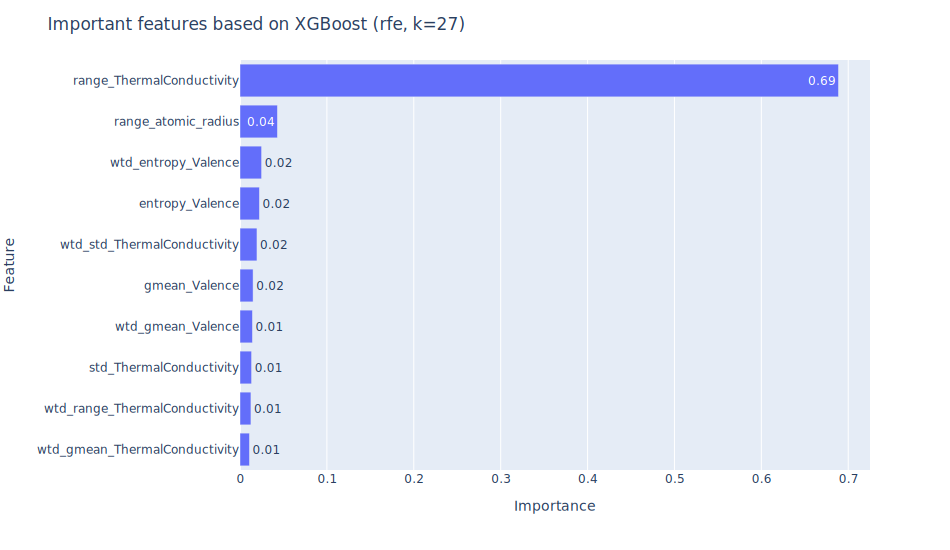

In [196]:
fig = px.bar(x=topten_xgb_rfe.importance[::-1], y=topten_xgb_rfe.feature[::-1], text_auto='.2f', width=950, height=550)
fig.update_layout(template = 'plotly', title='Important features based on XGBoost (rfe, k=27)',
                  yaxis_title='Feature',xaxis_title='Importance')
fig.show('svg')

***

## Result

Best model of XGBoost is rfe, k=27 and hyperparameters:
- 'colsample_bytree': 0.4615888288943831
- 'gamma': 0.5684339488686485
- 'learning_rate': 0.02860190243199159
- 'max_depth': 13.346533586546782
- 'n_estimators': 223.0251193099795
- 'reg_alpha': 0.6169339968747569
- 'reg_lambda': 0.9437480785146242
- 'subsample': 0.6850020961124486

In [197]:
y_pred = xgb_rfe.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'test rmse: {rmse:.2f}, r2: {r2:.2f}')

test rmse: 9.49, r2: 0.92


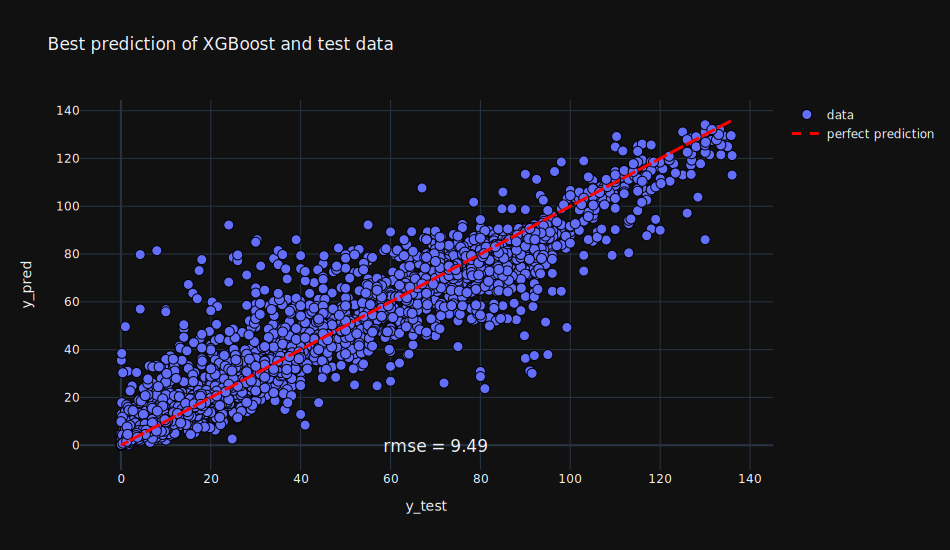

In [198]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_pred, name='data',mode='markers', 
                         marker=dict(size=10,line=dict(width=1, color='black'))))
fig.add_trace(go.Scatter(x=y_test, y=y_test, name='perfect prediction',mode='lines', 
                         line=dict(dash='dash', color='red', width=3)))
fig.add_annotation(x=70, y=0, text=f'rmse = {rmse:.2f}', showarrow=False,  font={'size':17})
fig.update_layout(template = 'plotly_dark', title='Best prediction of XGBoost and test data',yaxis_title='y_pred',
                  xaxis_title='y_test', showlegend=True, width=950, height=550)
fig.show('svg')

***

## PCA<a id='pca'><a>

Check explained variance ratio.

In [200]:
steps = [('scaler', StandardScaler()), ('pca', PCA())]
pipeline_pca = Pipeline(steps)
pipeline_pca.fit(X_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

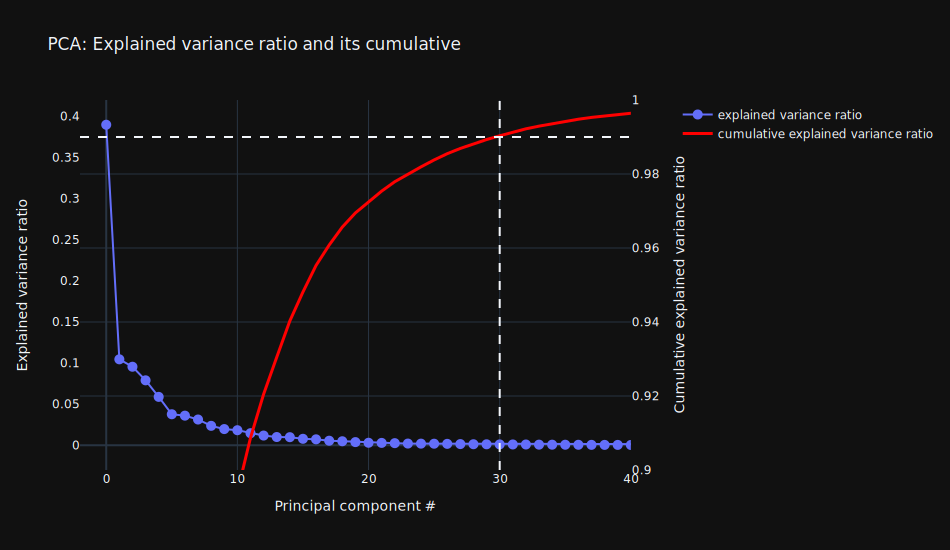

In [202]:
exp_var_ratio = pipeline_pca.named_steps.pca.explained_variance_ratio_
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=np.arange(0, len(exp_var_ratio)), y=exp_var_ratio, name='explained variance ratio',
                         mode='lines+markers', marker=dict(size=10)), secondary_y=False)
fig.add_trace(go.Scatter(x=np.arange(0, len(exp_var_ratio)), y=exp_var_ratio.cumsum(), 
                         name='cumulative explained variance ratio',
                         mode='lines', line=dict(color='red', width=3)), secondary_y=True)

fig.add_vline(x=30, line_width=2, line_dash="dash")
fig.add_hline(y=0.99, line_width=2, line_dash="dash", secondary_y=True)

fig.update_xaxes(range=[-2, 40],showgrid=True)

fig.update_yaxes(title_text="Explained variance ratio", showgrid=False,secondary_y=False)
fig.update_yaxes(title_text="Cumulative explained variance ratio", showgrid=True, range=[0.9,1],secondary_y=True)

fig.update_layout(template = 'plotly_dark', title='PCA: Explained variance ratio and its cumulative',
                  xaxis_title='Principal component #', showlegend=True, width=950, height=550)
fig.show('svg')

Cumulative explained variance of 0.99 are at PC30. 

$\therefore$ Try n_components = 31.

In [203]:
steps = [('scaler', StandardScaler()), ('pca', PCA(31, random_state=0)), ('xgb', xgb.XGBRegressor(**params))]
pipeline_xgb_pca = Pipeline(steps)
xgb_pca_score = cross_val_score(pipeline_xgb_pca, X_train, y_train, scoring='neg_root_mean_squared_error', cv=kf)

In [204]:
-xgb_pca_score.mean(), xgb_pca_score.std()

(10.296865561579962, 0.3880784344178253)

Not very good.

In [ ]:
steps = [('scaler', StandardScaler()), ('pca', PCA()), ('rfe', RFE(xgb.XGBRegressor(**params)))]
pipeline_xgb_rfe_pca = Pipeline(steps)
n = [n for n in range(1, X_train.shape[1]+1)]
parameters = {'rfe__n_features_to_select':n}
xgb_rfe_pca_cv = GridSearchCV(pipeline_xgb_rfe_pca, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=kf)
xgb_rfe_pca_cv.fit(X_train, y_train)

***

## Selectkbest(f_regression) -> PCA

Use pca with features from selectkbest(f_regression).

In [448]:
X_train_f = xgb_k_cv.best_estimator_.named_steps.selectkbest.transform(X_train)
X_test_f = xgb_k_cv.best_estimator_.named_steps.selectkbest.transform(X_test)
pca_f = PCA()
pca_f.fit(X_train_mi)

PCA()

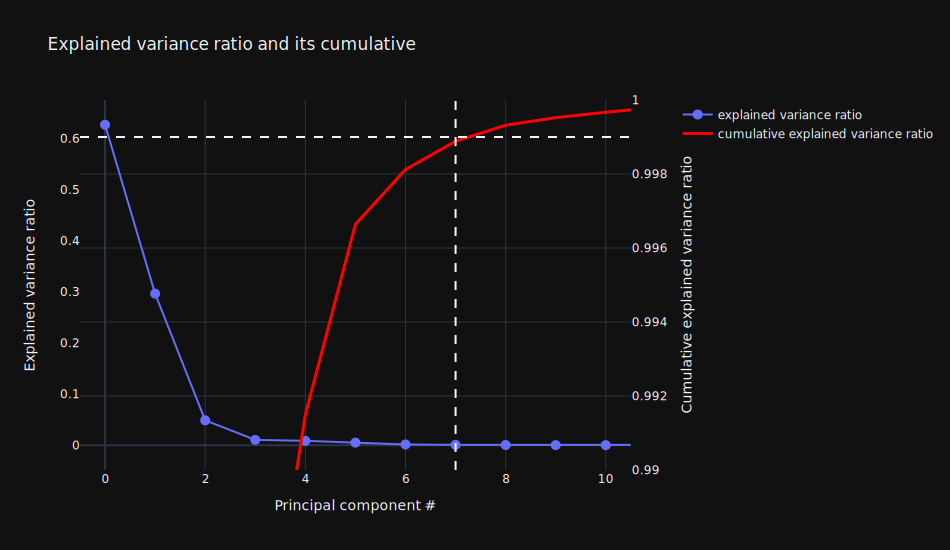

In [449]:
exp_var_ratio = pca_mi.explained_variance_ratio_
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=np.arange(0, len(exp_var_ratio)), y=exp_var_ratio, name='explained variance ratio',
                         mode='lines+markers', marker=dict(size=10)), secondary_y=False)
fig.add_trace(go.Scatter(x=np.arange(0, len(exp_var_ratio)), y=exp_var_ratio.cumsum(), 
                         name='cumulative explained variance ratio',
                         mode='lines', line=dict(color='red', width=3)), secondary_y=True)

fig.add_vline(x=7, line_width=2, line_dash="dash")
fig.add_hline(y=0.999, line_width=2, line_dash="dash", secondary_y=True)

fig.update_xaxes(range=[-0.5, 10.5],showgrid=True)

fig.update_yaxes(title_text="Explained variance ratio", showgrid=False,secondary_y=False)
fig.update_yaxes(title_text="Cumulative explained variance ratio", showgrid=True, range=[0.99, 1],secondary_y=True)

fig.update_layout(template = 'plotly_dark', title='Explained variance ratio and its cumulative',
                  xaxis_title='Principal component #', showlegend=True, width=950, height=550)
fig.show('svg')

Cumulative explained variance of 0.999 are at basis 7.

Try n_components = 8.

In [464]:
steps = [('scaler', StandardScaler()), ('pca', PCA(8, random_state=0)), ('xgb', xgb.XGBRegressor(**params))]
pipeline_xgb_f_pca = Pipeline(steps)
xgb_f_score = cross_val_score(pipeline_xgb_f_pca, X_train_f, y_train, scoring='neg_root_mean_squared_error', cv=kf)

In [465]:
-xgb_f_score.mean(), xgb_f_score.std()

(12.14034880619431, 0.3488331812493199)

In [468]:
steps = [('scaler', StandardScaler()), ('pca', PCA(8, random_state=0)), ('xgb', xgb.XGBRegressor(**params))]
pipeline_xgb_f_pca = Pipeline(steps)
pipeline_xgb_f_pca.fit(X_train_f, y_train)
y_pred = pipeline_xgb_f_pca.predict(X_test_f)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'test rmse: {rmse:.2f}, r2: {r2:.2f}')

test rmse: 12.01, r2: 0.88


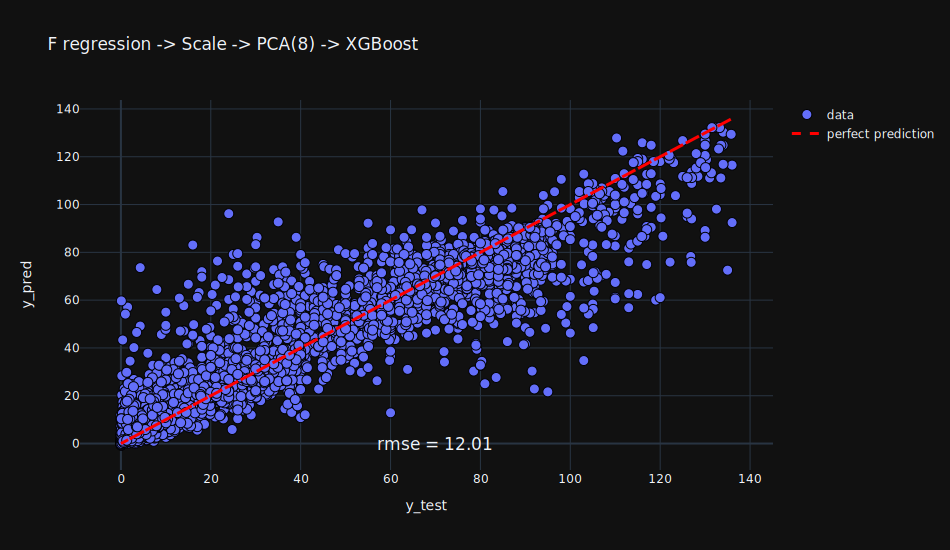

In [470]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_pred, name='data',mode='markers', 
                         marker=dict(size=10,line=dict(width=1, color='black'))))
fig.add_trace(go.Scatter(x=y_test, y=y_test, name='perfect prediction',mode='lines', 
                         line=dict(dash='dash', color='red', width=3)))
fig.add_annotation(x=70, y=0, text=f'rmse = {rmse:.2f}', showarrow=False,  font={'size':17})
fig.update_layout(template = 'plotly_dark', title='F regression -> Scale -> PCA(8) -> XGBoost',yaxis_title='y_pred',
                  xaxis_title='y_test', showlegend=True, width=950, height=550)
fig.show('svg')

***

## Selectkbest(mutual_info_regression) -> PCA

Use pca with features from selectkbest(mutual_info_regression).

In [444]:
X_train_mi = xgb_mi_cv.best_estimator_.named_steps.selectkbest.transform(X_train)
X_test_mi = xgb_mi_cv.best_estimator_.named_steps.selectkbest.transform(X_test)
pca_mi = PCA()
pca_mi.fit(X_train_mi)

PCA()

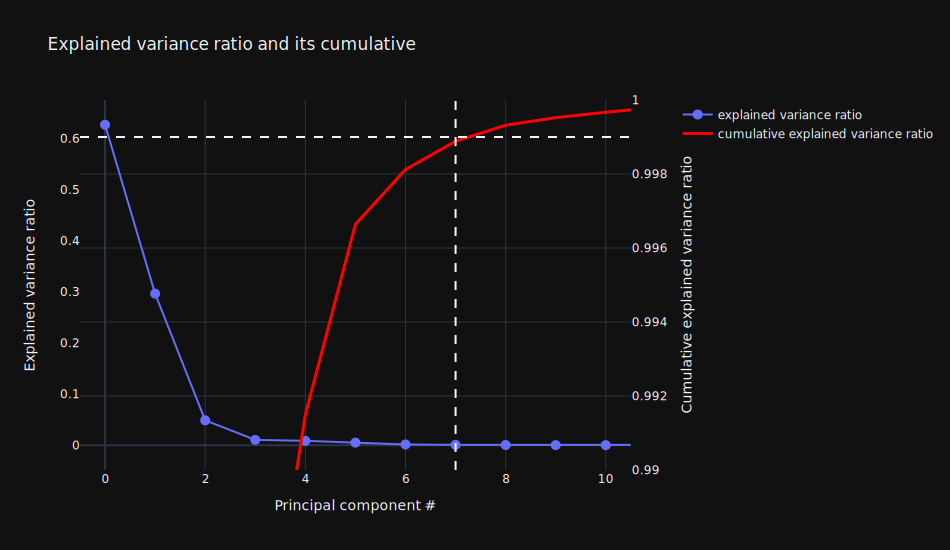

In [445]:
exp_var_ratio = pca_mi.explained_variance_ratio_
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=np.arange(0, len(exp_var_ratio)), y=exp_var_ratio, name='explained variance ratio',
                         mode='lines+markers', marker=dict(size=10)), secondary_y=False)
fig.add_trace(go.Scatter(x=np.arange(0, len(exp_var_ratio)), y=exp_var_ratio.cumsum(), 
                         name='cumulative explained variance ratio',
                         mode='lines', line=dict(color='red', width=3)), secondary_y=True)

fig.add_vline(x=7, line_width=2, line_dash="dash")
fig.add_hline(y=0.999, line_width=2, line_dash="dash", secondary_y=True)

fig.update_xaxes(range=[-0.5, 10.5],showgrid=True)

fig.update_yaxes(title_text="Explained variance ratio", showgrid=False,secondary_y=False)
fig.update_yaxes(title_text="Cumulative explained variance ratio", showgrid=True, range=[0.99, 1],secondary_y=True)

fig.update_layout(template = 'plotly_dark', title='Explained variance ratio and its cumulative',
                  xaxis_title='Principal component #', showlegend=True, width=950, height=550)
fig.show('svg')

Cumulative explained variance of 0.999 are at basis 7.

Try n_components = 8.

In [466]:
steps = [('scaler', StandardScaler()), ('pca', PCA(8, random_state=0)), ('xgb', xgb.XGBRegressor(**params))]
pipeline_xgb_mi_pca = Pipeline(steps)
xgb_mi_score = cross_val_score(pipeline_xgb_mi_pca, X_train_mi, y_train, scoring='neg_root_mean_squared_error', cv=kf)

In [467]:
-xgb_mi_score.mean(), xgb_mi_score.std()

(11.972007255382575, 0.2797502311909165)

In [441]:
steps = [('scaler', StandardScaler()), ('pca', PCA(8, random_state=0)), ('xgb', xgb.XGBRegressor(**params))]
pipeline_xgb_mi_pca = Pipeline(steps)
pipeline_xgb_mi_pca.fit(X_train_mi, y_train)
y_pred = pipeline_xgb_mi_pca.predict(X_test_mi)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'test rmse: {rmse:.2f}, r2: {r2:.2f}')

test rmse: 11.49, r2: 0.89


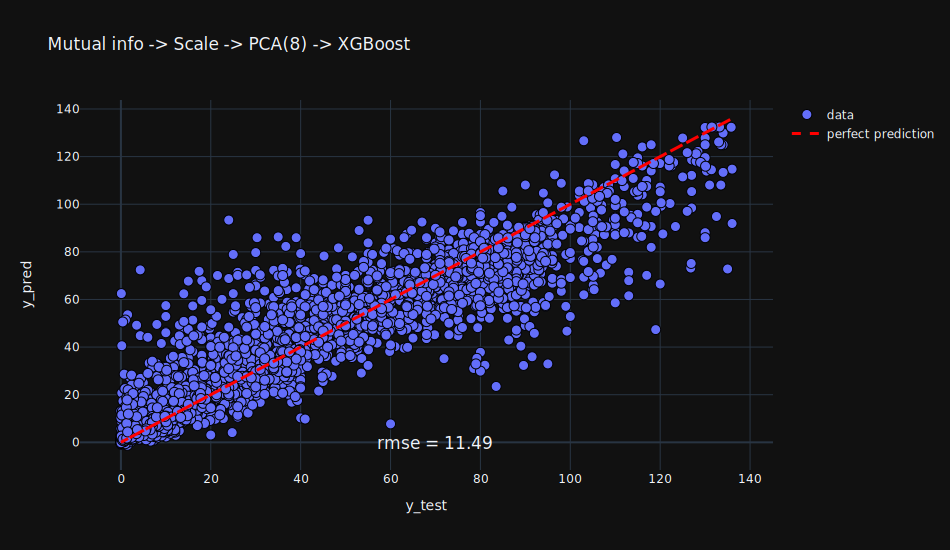

In [443]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_pred, name='data',mode='markers', 
                         marker=dict(size=10,line=dict(width=1, color='black'))))
fig.add_trace(go.Scatter(x=y_test, y=y_test, name='perfect prediction',mode='lines', 
                         line=dict(dash='dash', color='red', width=3)))
fig.add_annotation(x=70, y=0, text=f'rmse = {rmse:.2f}', showarrow=False,  font={'size':17})
fig.update_layout(template = 'plotly_dark', title='Mutual info -> Scale -> PCA(8) -> XGBoost',yaxis_title='y_pred',
                  xaxis_title='y_test', showlegend=True, width=950, height=550)
fig.show('svg')

***

# Save best model

In [494]:
xgb_mi_model = xgb_mi_cv
xgb_mi_model.version = '1.0'
xgb_mi_model.python_version = sys.version
xgb_mi_model.pandas_version = pd.__version__
xgb_mi_model.numpy_version = np.__version__
xgb_mi_model.sklearn_version = sklearn_version
xgb_mi_model.X_columns = [col for col in X.columns[xgb_mi_cv.best_estimator_.named_steps.selectkbest.get_support()]]
xgb_mi_model.build_datetime = datetime.datetime.now()

modelpath = '../models'
dump(xgb_mi_model, f'{modelpath}/xgb_mi_model.joblib')

['../models/xgb_mi_model.joblib']